<a href="https://colab.research.google.com/github/entirety2019/Meetup2019/blob/master/Session3/Densenet_cifar_10_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Resources:**
<br>
1. https://github.com/bamos/densenet.pytorch/blob/master/train.py
2. https://github.com/kuangliu/pytorch-cifar/blob/master/main.py
3. https://github.com/bearpaw/pytorch-classification/tree/master/models

In [1]:
!pip install torch torchvision
!pip install Pillow==4.0.0

    100% |████████████████████████████████| 2.0MB 1.6MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


    100% |████████████████████████████████| 5.6MB 8.0MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1


In [0]:
import torch
import numpy as np
import copy
import time

import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torchvision.models as models

In [3]:
data = dset.CIFAR10(root='cifar', train=True, download=True,
                    transform=transforms.ToTensor())

In [4]:
#never divide the data and then perform normalization just do the normalization part divide is uneccessary and may degrade the accuracy 
print("Shape of the data",data.train_data.shape)
means = np.mean(data.train_data , axis=(0,1,2))
stdevs = np.std(data.train_data , axis=(0,1,2))
print("means: {}".format(means))
print("stdevs: {}".format(stdevs))
print('transforms.Normalize(mean = {}, std = {})'.format(means, stdevs))

Shape of the data (50000, 32, 32, 3)
means: [125.30691805 122.95039414 113.86538318]
stdevs: [62.99321928 62.08870764 66.70489964]
transforms.Normalize(mean = [125.30691805 122.95039414 113.86538318], std = [62.99321928 62.08870764 66.70489964])


In [0]:
trainLoader = DataLoader(data , batch_size=16,shuffle=True)
# Data loader. Combines a dataset and a sampler, and provides single- or multi-process iterators over the dataset.

classes = ('plane', 'car', 'bird', 'cat' , 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')# cifar 10 classes

In [0]:
def denormalize(image):
  #because pytorch takes data in C * H * W  order we need to convert to H * W* C for visualizing in pytorch
  image = image.permute(1,2,0) # it transposes the dimensions
  return image

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([125.30691805, 122.95039414, 113.86538318])
        std = np.array([62.99321928, 62.08870764, 66.70489964])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
   
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    plt.grid(False)
    plt.title(title)
    plt.show()
    

    return ax


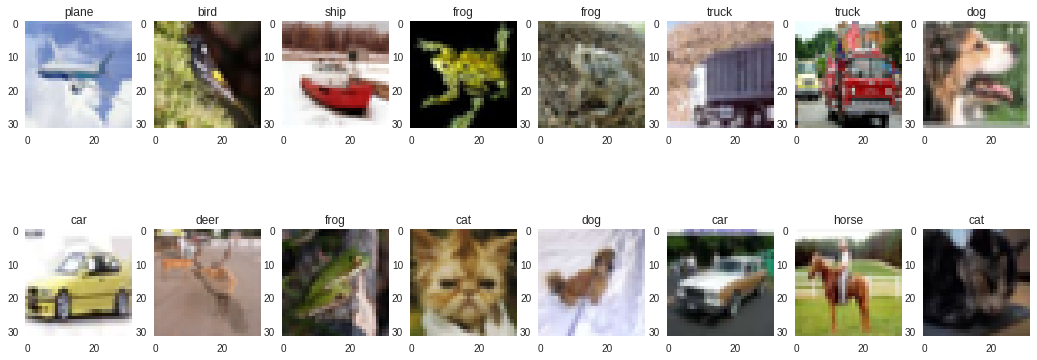

In [8]:
from matplotlib import pyplot as plt
#As we can see we have given batch size of 16 so
# visualizing the image

data = next(iter(trainLoader))
images , labels = data
nrows=2
ncols = len(data[0])//nrows 
plt.figure(figsize=(18,7))
for i in range(len(images)):
  plt.subplot(nrows,ncols,i+1)
  plt.grid(False)
  plt.imshow(denormalize(images[i]))
  plt.title(classes[labels[i]])
plt.show()
  

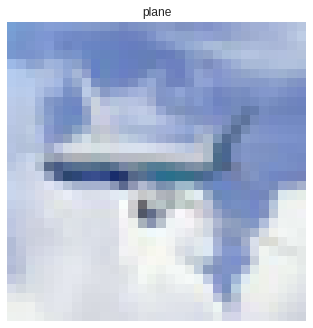

In [9]:
imshow(images[0],title=classes[labels[0]],normalize=False)

In [0]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((125.30691805, 122.95039414 ,113.86538318),(62.99321928 ,62.08870764, 66.70489964))])


In [11]:

trainset = dset.CIFAR10(root='cifar10', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = dset.CIFAR10('cifar10_test', download=True, train=False, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

In [12]:
model = models.densenet121(pretrained=True)

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 35404282.39it/s]


In [13]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [14]:
num_features = model.classifier.in_features # get the no of on_features in last Linear unit
print(num_features)

1024


In [0]:
feature_lst=[num_features,num_features//2,num_features//4]
num_classes=10
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                      ('hidden1', nn.Linear(feature_lst[0], feature_lst[1])),
                      ('relu1', nn.ReLU()),
                      ('bn1',nn.BatchNorm1d(feature_lst[1])),
                      ('dpt1',nn.Dropout(0.5)),
                      ('hidden2',nn.Linear(feature_lst[1],feature_lst[2])),
                      ('relu2',nn.ReLU()),
                      ('bn2',nn.BatchNorm1d(feature_lst[2])),
                      ('dpt2',nn.Dropout(0.5)),
                      ('output', nn.Linear(feature_lst[2], num_classes)),
                      ('log_softmax', nn.LogSoftmax(dim=1))]))

In [0]:
model.classifier=classifier

In [17]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [0]:
for param in model.parameters():
    param.requires_grad = False
    
model=model.cuda()

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [20]:
epochs = 5
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images=images.cuda()
        labels=labels.cuda()
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss=0
        accuracy=0
        with torch.no_grad():
            for images,labels in testloader:
                images=images.cuda()
                labels=labels.cuda()
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps = torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

RuntimeError: ignored

** Can you understand the error above**

**Downloading the Densent Architeture for Cifar10**

In [21]:
!wget https://raw.githubusercontent.com/bamos/densenet.pytorch/master/densenet.py

--2019-01-31 10:37:30--  https://raw.githubusercontent.com/bamos/densenet.pytorch/master/densenet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4100 (4.0K) [text/plain]
Saving to: ‘densenet.py’

densenet.py         100%[===================>]   4.00K  --.-KB/s    in 0s      

2019-01-31 10:37:30 (99.0 MB/s) - ‘densenet.py’ saved [4100/4100]



In [0]:
from densenet import DenseNet
model = DenseNet(growthRate=12, depth=100, reduction=0.5,
                            bottleneck=True, nClasses=10)

In [23]:
model

DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (2): Bottleneck(
      (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [0]:
optimizer = optim.SGD(model.parameters(), lr=1e-1,
                            momentum=0.9, weight_decay=1e-4)
criterion = nn.NLLLoss()
model=model.cuda()

In [25]:
epochs = 15
since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images=images.cuda()
        labels=labels.cuda()
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss=0
        accuracy=0
        with torch.no_grad():
            for images,labels in testloader:
                images=images.cuda()
                labels=labels.cuda()
                log_ps=model(images)
                test_loss+=criterion(log_ps,labels)
                ps = torch.exp(log_ps)
                top_p,top_class=ps.topk(1,dim=1)
                equals=top_class==labels.view(*top_class.shape)
                accuracy+=torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        curr_acc=accuracy/len(testloader)
        if curr_acc > best_acc:
                best_acc = curr_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save({'arch': 'densenet','state_dict': model.state_dict()}, 'densenet_cifar10.pth')
                print("Model Weights saved")

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        time_elapsed = time.time() - since
        print('Total Training time {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

/content/densenet.py:115: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(self.fc(out))


Model Weights saved
Epoch: 1/15..  Training Loss: 1.768..  Test Loss: 1.396..  Test Accuracy: 0.487
Total Training time 5m 34s
Model Weights saved
Epoch: 2/15..  Training Loss: 1.133..  Test Loss: 0.946..  Test Accuracy: 0.664
Total Training time 11m 9s
Model Weights saved
Epoch: 3/15..  Training Loss: 0.815..  Test Loss: 0.775..  Test Accuracy: 0.728
Total Training time 16m 43s
Model Weights saved
Epoch: 4/15..  Training Loss: 0.669..  Test Loss: 0.679..  Test Accuracy: 0.769
Total Training time 22m 18s
Model Weights saved
Epoch: 5/15..  Training Loss: 0.580..  Test Loss: 0.656..  Test Accuracy: 0.776
Total Training time 27m 53s
Model Weights saved
Epoch: 6/15..  Training Loss: 0.514..  Test Loss: 0.572..  Test Accuracy: 0.805
Total Training time 33m 28s
Model Weights saved
Epoch: 7/15..  Training Loss: 0.470..  Test Loss: 0.571..  Test Accuracy: 0.806
Total Training time 39m 3s
Model Weights saved
Epoch: 8/15..  Training Loss: 0.428..  Test Loss: 0.559..  Test Accuracy: 0.811
Total T

In [26]:
!ls

cifar	 cifar10_test	       densenet.py  sample_data
cifar10  densenet_cifar10.pth  __pycache__
